# Supply Trend 

This is a very useful example combining functionality from our *Vessel*, *Port*, *Voyages*, *Market Rates* and *Historical Tonnage List* APIs. The aim is to plot a supply trend with superimposed predicted market rates for getting a more hollistic insight of the market behaviour during the range of interest from a specific load port and vessel class.

## Setup

Install the Signal Ocean SDK:

In [ ]:
pip install signal-ocean

Import required libraries / APIs / packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta, time

from signal_ocean import PortAPI, VesselClassAPI, PortFilter, VesselClassFilter, MarketRatesAPI, Connection
from signal_ocean.voyages import VoyagesAPI
from signal_ocean.historical_tonnage_list import HistoricalTonnageListAPI, VesselFilter, PushType, MarketDeployment, CommercialStatus, VesselSubclass, IndexLevel

Fill in your personal SignalOcean API subscription key acquired <a href="https://apis.signalocean.com/profile" target="_blank">here</a> and open a connection:

In [2]:
signal_ocean_api_key = '' #fill with your subscription key
connection = Connection(signal_ocean_api_key)

Instantiate connections for all imported APIs:

In [3]:
port_api = PortAPI(connection)
vessel_class_api = VesselClassAPI(connection)
voyages_api = VoyagesAPI(connection)
htl_api = HistoricalTonnageListAPI(connection)
mr_api = MarketRatesAPI(connection)

## Parametrization

In order to plot a supply trend superimposed with the predicted market rates, we need to filter the query by specifying the following parameters:
1. **vessel_class:** Class of the Vessel.
2. **load_port:** The loading port.
3. **days_back:** Time window for plotting the supply trend, with current date as end date.
4. **max_eta:** Estimated Time of Arrival window for available vessels to reach the loading port.
5. **push_type:** Pushed status, if available from the emails in your account.
6. **market_deployment:** Market deployment, based on SignalOcean information. 
7. **commercial_status:** Commercial status of the vessel at each point in time.
8. **trade:** The type of product that the vessel is classified to carry.
9. **ais_since:** How many days since the vessel has transmitted its AIS.
10. **route_description:** The route of interest with available market rates.

In [4]:
vessel_class = 'Aframax'
load_port = 'Ceyhan'
days_back = 90                  
max_eta = 10                     
    
push_type = [PushType.PUSHED_POSS, PushType.PUSHED]
market_deployment = [MarketDeployment.RELET, MarketDeployment.SPOT]
commercial_status = [CommercialStatus.AVAILABLE, CommercialStatus.ON_SUBS, CommercialStatus.FAILED, CommercialStatus.CANCELLED]
trade = VesselSubclass.DIRTY
ais_since = 5

route_description = 'Afra - Med'

In [5]:
today = datetime.utcnow().date()
start_date = today - timedelta(days=days_back)
end_date = today

For more information, the user can refer to the respective documentation in the <a href="https://signaloceansdk.github.io/SignalSDK/historical_tonnage_list/" target="_blank">Historical Tonnage List</a> and  <a href="https://signaloceansdk.github.io/SignalSDK/market_rates/" target="_blank">Market Rates</a> API sections.

Instantiate the vessel filter based on the specified parameters:

In [6]:
vessel_filter = VesselFilter(
    push_types=push_type,
    market_deployments=market_deployment,
    commercial_statuses=commercial_status,
    vessel_subclass=trade,
    latest_ais_since=ais_since
)

### Apply filters and extract tonnage list

Get information about the specified vessel class and load port by utilising the <a href="https://signaloceansdk.github.io/SignalSDK/vessels/#signal_ocean.vessels.vessels_api.VesselsAPI.get_vessel_classes" target="_blank">VesselClassAPI</a>, <a href="https://signaloceansdk.github.io/SignalSDK/port_expenses/#signal_ocean.port_expenses.port_expenses_api.PortExpensesAPI.get_ports" target="_blank">PortAPI</a> as well as VesselClassFilter and PortFilter in order to search for entries best matching the input parameters.

In [7]:
vessel_class = vessel_class_api.get_vessel_classes(VesselClassFilter(name_like=vessel_class))[0] 
port = port_api.get_ports(PortFilter(name_like=load_port))[0]

Call the Historical Tonnage List API to import the data:

In [8]:
htl = htl_api.get_historical_tonnage_list(
    loading_port=port,
    vessel_class=vessel_class,
    laycan_end_in_days=max_eta,
    start_date=start_date,
    end_date=end_date,
    vessel_filter=vessel_filter 
)

htl_for_supply_trend = htl.to_data_frame()
htl_for_supply_trend

name vessel_class ice_class  \
date                      imo                                               
2021-07-05 00:00:00+00:00 9297333    Minerva Clara      Aframax        1A   
                          9338905     Aegean Power      Aframax       NaN   
                          9370848    Anafi Warrior      Aframax       NaN   
                          9288734       Seabravery      Aframax        1C   
                          9337406        Banda Sea      Aframax       NaN   
...                                            ...          ...       ...   
2021-04-06 00:00:00+00:00 9299719      NS Champion      Aframax       NaN   
                          9787194  Minerva Olympia      Aframax       NaN   
                          9814428       Cobalt Sun      Aframax       NaN   
                          9338905     Aegean Power      Aframax       NaN   
                          9308833           Lovina      Aframax       NaN   

                                   year_built  deadweight  length_overall  \
date                      imo                                               
2021-07-05 00:00:00+00:00 9297333        2006      103232          244.00   
                          9338905        2007      115754          248.95   
                          9370848        2009      107593          243.80   
                          9288734        2005      105042          243.96   
                          9337406        2007      105576          237.71   
...                                       ...         ...             ...   
2021-04-06 00:00:00+00:00 9299719        2005      110084          244.00   
                          9787194        2019      114780          250.00   
                          9814428        2019      114395          249.90   
                          9338905        2007      115754          248.95   
                          9308833        2005      105047          243.80   

                                   breadth_extreme subclass  \
date                      imo                                 
2021-07-05 00:00:00+00:00 9297333               42    Dirty   
                          9338905               44    Dirty   
                          9370848               42    Dirty   
                          9288734               42    Dirty   
                          9337406               42    Dirty   
...                                            ...      ...   
2021-04-06 00:00:00+00:00 9299719               42    Dirty   
                          9787194               44    Dirty   
                          9814428               44    Dirty   
                          9338905               44    Dirty   
                          9308833               42    Dirty   

                                  market_deployment_point_in_time  \
date                      imo                                       
2021-07-05 00:00:00+00:00 9297333                            Spot   
                          9338905                            Spot   
                          9370848                            Spot   
                          9288734                            Spot   
                          9337406                            Spot   
...                                                           ...   
2021-04-06 00:00:00+00:00 9299719                            Spot   
                          9787194                            Spot   
                          9814428                            Spot   
                          9338905                            Spot   
                          9308833                            Spot   

                                  push_type_point_in_time  ...  \
date                      imo                              ...   
2021-07-05 00:00:00+00:00 9297333                  Pushed  ...   
                          9338905                  Pushed  ...   
                          9370848                  Pushed  .

### Get daily market rates for the vessel route 

In [9]:
def return_selected_route(vessel_class, route_description):
    vessel_routes = mr_api.get_routes(vessel_class_id=vessel_class.id)
    for i,v in enumerate(vessel_routes):
        if vessel_routes[i].description == route_description:
            break
    return vessel_routes[i]

In [10]:
mr_route = return_selected_route(vessel_class, route_description)
market_rates = mr_api.get_market_rates(start_date, route_id=mr_route.id, vessel_class_id=vessel_class.id, end_date=end_date)
market_rates = pd.DataFrame([vars(vr) for vr in market_rates]) 
market_rates['rate_date'] = pd.to_datetime(market_rates['rate_date'])
market_rates.set_index('rate_date', inplace=True) 
market_rates

,route_id,rate_value,unit,vessel_class_id
rate_date,,,,
2021-04-06,R1,120.0,WS,86
2021-04-07,R1,112.5,WS,86
2021-04-08,R1,105.0,WS,86
2021-04-09,R1,95.0,WS,86
2021-04-10,R1,95.0,WS,86
...,...,...,...,...
2021-07-01,R1,87.5,WS,86
2021-07-02,R1,87.5,WS,86
2021-07-03,R1,87.5,WS,86


## Plot: daily supply trend with market rates

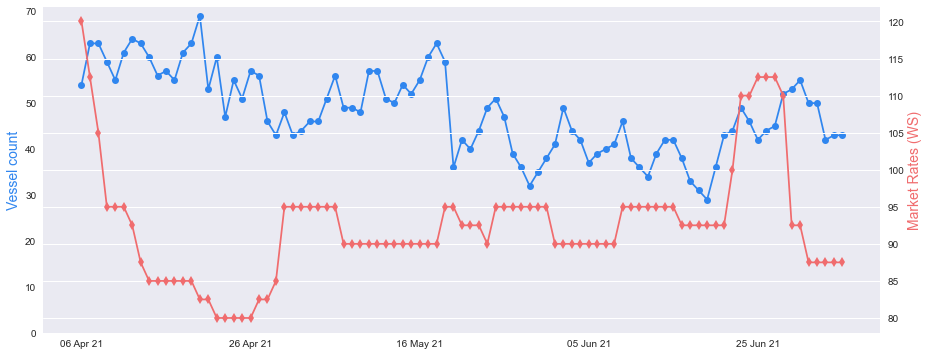

In [11]:
plt.style.use('seaborn')
fig, axs = plt.subplots(figsize=(15,6))

supply_trend = htl_for_supply_trend.groupby(IndexLevel.DATE, sort=True).size()
supply_trend.index = supply_trend.index.strftime('%d %b %y')

# Left axis (Supply plot)
supply_plot = supply_trend.plot(ax=axs, x='date', color='#3086EF', marker='o')
supply_plot.set_ylabel('Vessel count', color=plt.gca().lines[-1].get_color(), fontsize=14)
supply_plot.set_ylim(ymin=0)

# Right axis (Market rate plot)
market_rates.index = market_rates.index.strftime('%d %b %y')
mr_plot = market_rates.plot(ax=axs, y='rate_value', secondary_y=True, color='#F06C6E', marker='d')
mr_plot.set_ylabel('Market Rates (WS)', color=plt.gca().lines[-1].get_color(), fontsize=14)

axs.set_xlabel('')
axs.get_legend().remove()

## Point to Point comparison

Workflow to compare two different points in time (days) in order to solve discrepancies.
Specify dates to compare:

In [12]:
point_A = date(2021,5,12)
point_B = date(2021,6,13)

In [13]:
date_values = htl_for_supply_trend.index.get_level_values('date').date

if not any(date_values == point_A):
    raise SyntaxError('Point A is not within imported date values.')
elif not any(date_values == point_B):
    raise SyntaxError('Point B is not within imported date values.')
        
vessels_in_A = htl_for_supply_trend.loc[(date_values == point_A)]
vessels_in_B = htl_for_supply_trend.loc[(date_values == point_B)]

### Intersection of Vessel IMOs

In [14]:
intersection = pd.merge(vessels_in_A.add_suffix('_IN_A'), vessels_in_B.add_suffix('_IN_B'), how ='inner', on ='imo')
intersection

,name_IN_A,vessel_class_IN_A,ice_class_IN_A,year_built_IN_A,deadweight_IN_A,length_overall_IN_A,breadth_extreme_IN_A,subclass_IN_A,market_deployment_point_in_time_IN_A,push_type_point_in_time_IN_A,...,commercial_operator_point_in_time_IN_B,commercial_status_point_in_time_IN_B,eta_point_in_time_IN_B,latest_ais_point_in_time_IN_B,open_prediction_accuracy_point_in_time_IN_B,open_country_point_in_time_IN_B,open_narrow_area_point_in_time_IN_B,open_wide_area_point_in_time_IN_B,availability_port_type_point_in_time_IN_B,availability_date_type_point_in_time_IN_B
imo,,,,,,,,,,,,,,,,,,,,,
9296195,Paros,Aframax,NaN,2003,107197,247.00,42,Dirty,Spot,Pushed,...,New Shipping,Available,2021-06-16 10:00:00+00:00,2021-06-12 18:41:59+00:00,Narrow Area,Malta,Central Mediterranean,Mediterranean,Source,Source
9306782,NS Century,Aframax,NaN,2006,109989,244.00,42,Dirty,Spot,Pushed,...,Sovcomflot,Available,2021-06-23 00:00:00+00:00,2021-06-10 07:32:20+00:00,Port,Turkey,Sea of Marmara,Black Sea / Sea Of Marmara,Source,Prediction
9801976,Prometheus Light,Aframax,NaN,2019,114700,249.99,44,Dirty,Spot,Pushed,...,Kyklades Maritime,Available,2021-06-21 01:00:00+00:00,2021-06-12 20:34:16+00:00,Port,Spain,West Mediterranean,Mediterranean,Source,Prediction
9334727,Dugi Otok,Aframax,1C,2008,108414,246.00,48,Dirty,Spot,Pushed,...,Tankerska Plovidba dd,On Subs,2021-06-16 06:00:00+00:00,2021-06-12 18:42:50+00:00,Narrow Area,Malta,Central Mediterranean,Mediterranean,Source,Source
9823041,Alfa Finlandia,Aframax,NaN,2019,109089,228.60,44,Dirty,Spot,Pushed,...,Lundqvist Rederierna,Available,2021-06-20 08:00:00+00:00,2021-06-12 23:07:18+00:00,Port,Greece,East Mediterranean,Mediterranean,Source,Source
9304825,Seamaster IV,Aframax,NaN,2006,109266,243.00,42,Dirty,Spot,Pushed,...,Thenamaris,Available,2021-06-23 21:00:00+00:00,2021-06-12 18:13:28+00:00,Port,Italy,Central Mediterranean,Mediterranean,Source,Source
9389100,Myrtos,Aframax,NaN,2009,106969,243.80,42,Dirty,Spot,Pushed,...,Cardiff Marine,Available,2021-06-15 01:00:00+00:00,2021-06-12 20:31:55+00:00,Narrow Area,Greece,East Mediterranean,Mediterranean,Source,Source
9231468,Saint George,Aframax,NaN,2002,109390,244.60,42,Dirty,Relet,Pushed,...,Avin International,On Subs,2021-06-13 20:00:00+00:00,2021-06-12 23:08:01+00:00,Narrow Area,Cyprus,East Mediterranean,Mediterranean,Source,Source
9302970,Sealoyalty,Aframax,NaN,2005,106468,243.07,42,Dirty,Spot,Pushed,...,Thenamaris,Available,2021-06-22 01:00:00+00:00,2021-06-12 22:16:41+00:00,Port,Italy,Central Mediterranean,Mediterranean,Source,Prediction


### Difference between vessel IMOs w.r.t Point A

In [15]:
vessels_in_A_not_in_B = vessels_in_A.add_suffix('_IN_A').merge(vessels_in_B.add_suffix('_IN_B'), indicator=True, how='left', on='imo').loc[lambda x : x['_merge']!='both']
vessels_in_A_not_in_B

,name_IN_A,vessel_class_IN_A,ice_class_IN_A,year_built_IN_A,deadweight_IN_A,length_overall_IN_A,breadth_extreme_IN_A,subclass_IN_A,market_deployment_point_in_time_IN_A,push_type_point_in_time_IN_A,...,commercial_status_point_in_time_IN_B,eta_point_in_time_IN_B,latest_ais_point_in_time_IN_B,open_prediction_accuracy_point_in_time_IN_B,open_country_point_in_time_IN_B,open_narrow_area_point_in_time_IN_B,open_wide_area_point_in_time_IN_B,availability_port_type_point_in_time_IN_B,availability_date_type_point_in_time_IN_B,_merge
imo,,,,,,,,,,,,,,,,,,,,,
9656890,Fos Hamilton,Aframax,NaN,2013,105408,244.150,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9282481,Piper,Aframax,NaN,2005,114809,251.560,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9528031,Saga,Aframax,NaN,2011,115738,248.970,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9370848,Anafi Warrior,Aframax,NaN,2009,107593,243.800,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9791004,Front Polaris,Aframax,NaN,2018,109898,251.000,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9259680,Santa Cruz I,Aframax,NaN,2002,84999,238.940,38,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9235713,Astro Sculptor,Aframax,NaN,2003,105109,248.000,43,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9417440,Ohio,Aframax,NaN,2009,105188,243.970,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9780251,Front Castor,Aframax,NaN,2017,109900,251.000,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only


### Difference between vessel IMOs w.r.t Point B

In [16]:
vessels_in_B_not_in_A = vessels_in_B.add_suffix('_IN_B').merge(vessels_in_A.add_suffix('_IN_A'), indicator=True, how='left', on='imo').loc[lambda x : x['_merge']!='both']
vessels_in_B_not_in_A

,name_IN_B,vessel_class_IN_B,ice_class_IN_B,year_built_IN_B,deadweight_IN_B,length_overall_IN_B,breadth_extreme_IN_B,subclass_IN_B,market_deployment_point_in_time_IN_B,push_type_point_in_time_IN_B,...,commercial_status_point_in_time_IN_A,eta_point_in_time_IN_A,latest_ais_point_in_time_IN_A,open_prediction_accuracy_point_in_time_IN_A,open_country_point_in_time_IN_A,open_narrow_area_point_in_time_IN_A,open_wide_area_point_in_time_IN_A,availability_port_type_point_in_time_IN_A,availability_date_type_point_in_time_IN_A,_merge
imo,,,,,,,,,,,,,,,,,,,,,
9299733,Antaios,Aframax,NaN,2006,106005,243.96,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9332822,Taurus Sun,Aframax,NaN,2007,115577,243.80,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9232450,Nikki,Aframax,NaN,2002,106106,243.96,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9288863,Seaqueen,Aframax,NaN,2004,115639,249.87,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9313486,Ark,Aframax,NaN,2008,105804,240.50,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9439383,PS Genova,Aframax,NaN,2010,108983,243.00,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9332781,Mars Sun,Aframax,NaN,2006,115536,243.80,42,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9329409,Kriti Samaria,Aframax,NaN,2007,105865,241.03,42,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9384069,Saetta,Aframax,NaN,2009,107023,243.80,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
